In [1]:
import zipfile
%matplotlib inline
import numpy as np
import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import requests
import os
import geopandas as gpd
import matplotlib.pylab as pl
from fiona.crs import from_epsg
import fiona
import matplotlib.pylab as pl
from matplotlib import colors
import shapely
import seaborn as sns
from sklearn.cluster import KMeans
#add necessary libraries
import networkx as nx #library supporting networks
from shapely.geometry import Point, Polygon
import shapely as shp
import fiona
import pysal as ps

In [2]:
airport = gpd.GeoDataFrame.from_file('C:/spark/Flight_Project/Data/Airport_Codes_Lat_Lon.geojson')

In [3]:
airport.head(3)

,Airport,City,Latitude,Longitude,Name,Total_Flights,dest_count,geometry,id,origin_count
0,ABE,Allentown,40.652083,-75.440806,Lehigh Valley Intl,13044.0,6524.0,POINT (-75.440806 40.652083),0,6520.0
1,ABI,Abilene,32.411319,-99.681897,Abilene Rgnl,11045.0,5522.0,POINT (-99.68189700000001 32.411319),1,5523.0
2,ABQ,Albuquerque,35.040222,-106.609194,Albuquerque International Sunport,129212.0,64602.0,POINT (-106.6091944 35.0402222),2,64610.0


In [4]:
airport[airport.Airport=='ENV']

,Airport,City,Latitude,Longitude,Name,Total_Flights,dest_count,geometry,id,origin_count
106,ENV,Wendover,40.718694,-114.030889,Wendover,1.0,0.0,POINT (-114.030889 40.718694),106,1.0


In [5]:
thelinks = pd.read_csv('C:/spark/Flight_Project/Output/MostBussyRoute.csv')

In [6]:
for air in set(thelinks.ORIGIN.tolist()):
    if air in set(thelinks.DEST.tolist()):
        pass
    else:
        print air

ORIGIN
ENV
EFD
MCN
BFF


In [7]:
for air in set(thelinks.DEST.tolist()):
    if air in set(thelinks.ORIGIN.tolist()):
        pass
    else:
        print air

DEST


In [8]:
len(set(thelinks.DEST.tolist()))

331

In [9]:
len(set(thelinks.ORIGIN.tolist()))

335

In [10]:
thelinks.rename(columns={'count' :'Total_Flights'}, inplace=True)
thelinks.head()

,Unnamed: 0,ROUTE,Total_Flights,DEST,ORIGIN
0,0,"Row(_1=u'14771', _2=u'12892')",46097,LAX,SFO
1,1,"Row(_1=u'12892', _2=u'14771')",45400,SFO,LAX
2,2,"Row(_1=u'12478', _2=u'12892')",38230,LAX,JFK
3,3,"Row(_1=u'12892', _2=u'12478')",38223,JFK,LAX
4,4,"Row(_1=u'12889', _2=u'12892')",33892,LAX,LAS


In [11]:
thelinks[thelinks.ORIGIN=='ENV']

,Unnamed: 0,ROUTE,Total_Flights,DEST,ORIGIN
5114,5114,"Row(_1=u'11563', _2=u'11525')",1,EKO,ENV


In [12]:
thelinks.drop(thelinks[thelinks.ORIGIN=='ORIGIN'].index, inplace=True)

In [13]:
thelinks[thelinks.ORIGIN=='DEST']

,Unnamed: 0,ROUTE,Total_Flights,DEST,ORIGIN


In [14]:
G = nx.DiGraph()

In [15]:
for i in range(len(thelinks)):
    G.add_weighted_edges_from([(thelinks.ORIGIN.iloc[i],thelinks.DEST.iloc[i],thelinks.Total_Flights.iloc[i])])

In [16]:
def getXY(pt):
    return (pt.x, pt.y)

In [17]:
states = gpd.GeoDataFrame.from_file('C:/spark/Flight_Project/Data/cb_2016_us_state_500k/cb_2016_us_state_500k.shp')

In [18]:
airport['state'] = 0
for i in range(len(airport)):
    for j in range(len(states)):
        if airport.geometry.iloc[i].within(states.geometry.iloc[j]):
            airport.loc[i,'state'] = states.iloc[j]['NAME']

In [19]:
airport['longlat']=airport.geometry.map(getXY)
airportpos={}
airportstate={}
for pos in airport.index:
    airportpos[airport.Airport[pos]]=airport['longlat'][pos]
    airportstate[airport.Airport[pos]] = airport['state'][pos]

In [20]:
airportpos['JFK']

(-73.778925, 40.639751)

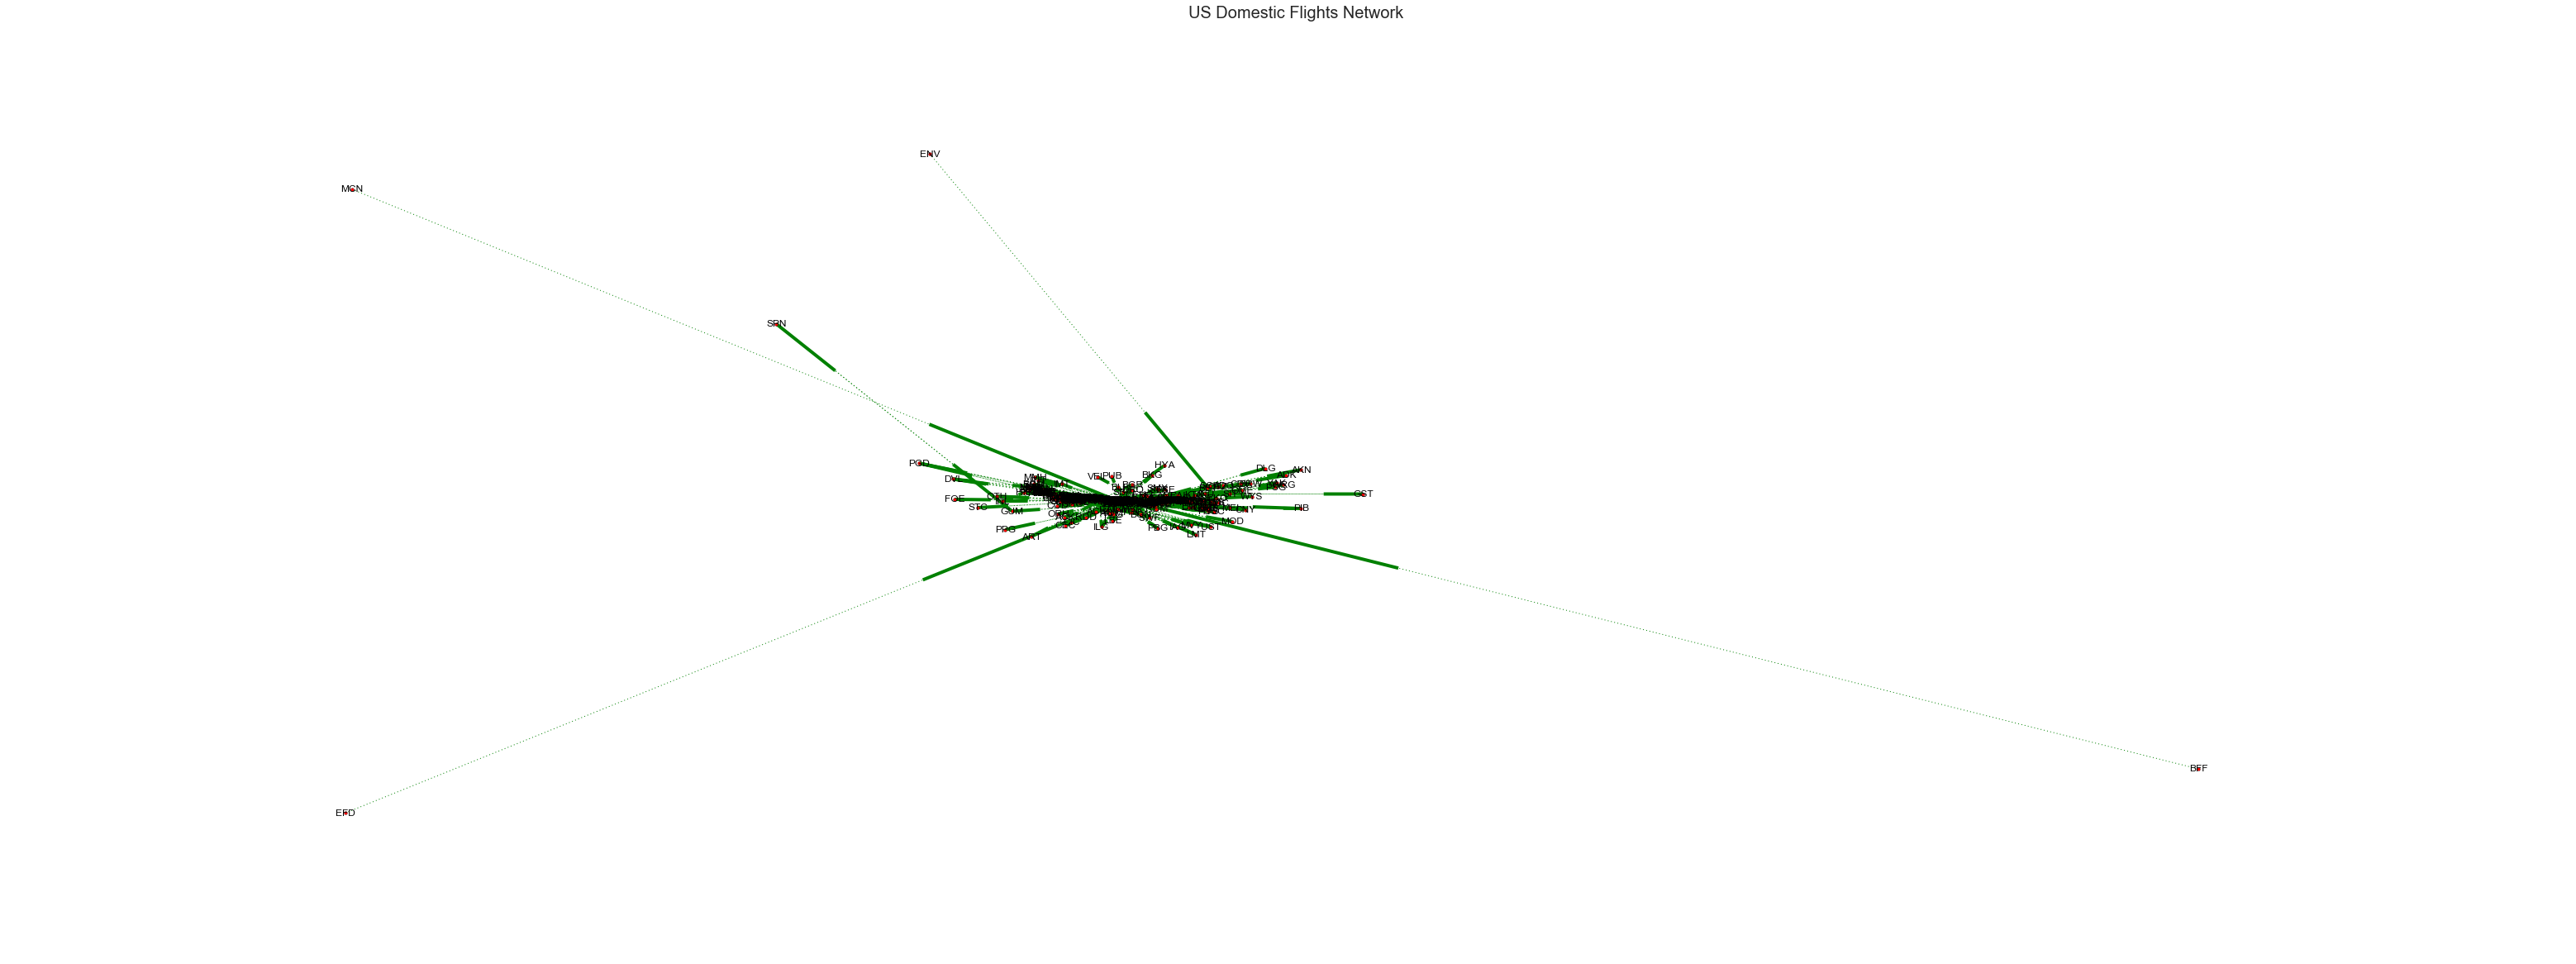

In [21]:
f, ax = pl.subplots(figsize=(55,20))

#states.plot(c = 'k', linewidth = .5, ax = ax,  color= 'Blue', label = 'parks')
pl.axis('off')

nx.draw(G,with_labels=True,arrows=True,node_size=15,style='dotted',edge_color='green')
pl.title("US Domestic Flights Network", size=20)

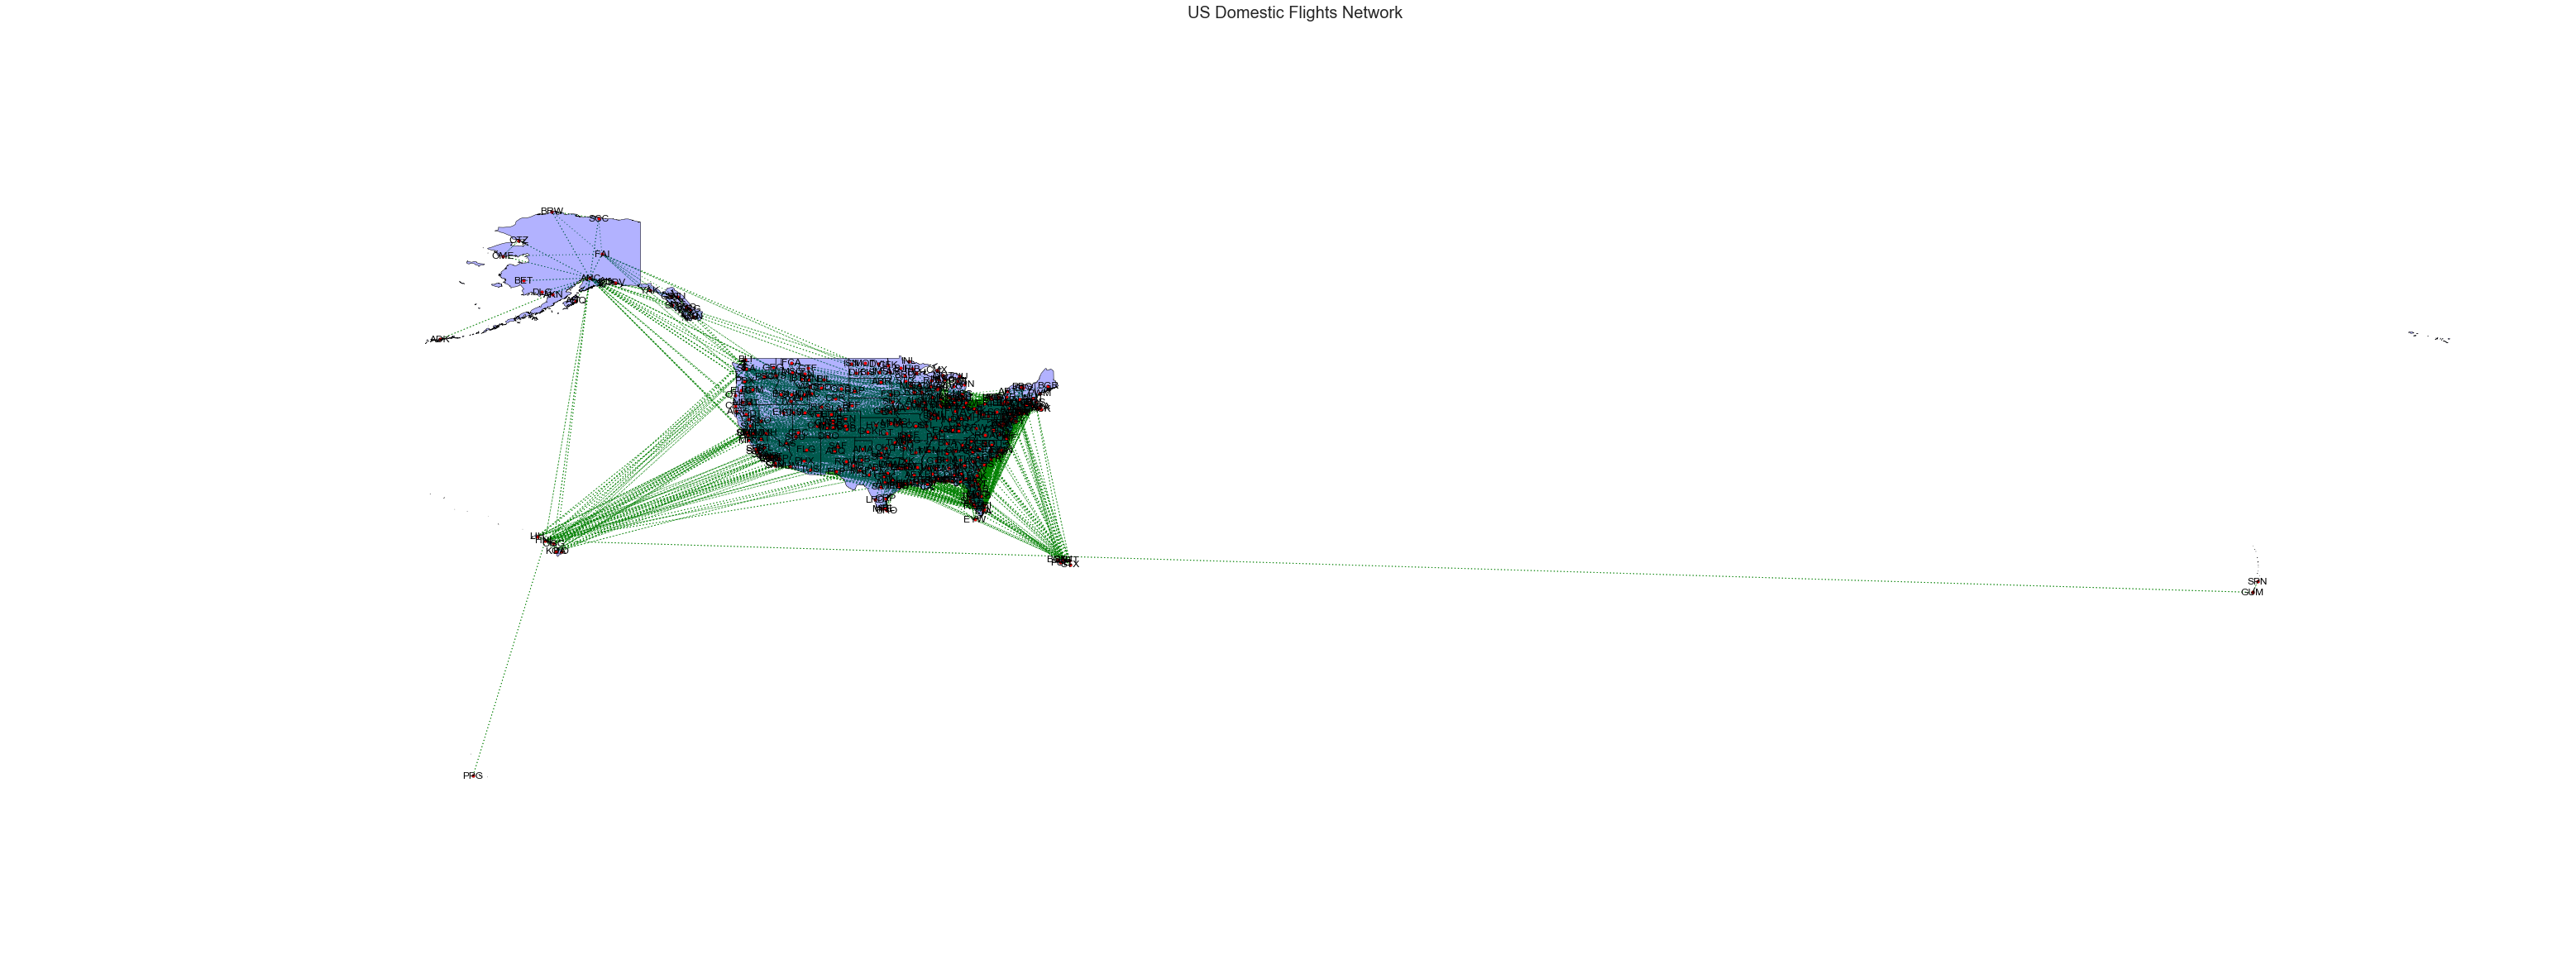

In [22]:
f, ax = pl.subplots(figsize=(55,20))

states.plot(c = 'k', linewidth = .5, ax = ax,  color= 'Blue', label = 'parks', alpha=.3)
pl.axis('off')

nx.draw(G,pos=airportpos,with_labels=True,arrows=False,node_size=15,style='dotted',edge_color='green')
pl.title("US Domestic Flights Network", size=20)

In [23]:
airportstate['ABE']

u'Pennsylvania'

In [24]:
for node in airportpos.keys():
    G.node[node]['x']=(airportpos[node][0])
    G.node[node]['y']=(airportpos[node][1])
    G.node[node]['state']= airportstate[node]

In [25]:
airport.head(3)

,Airport,City,Latitude,Longitude,Name,Total_Flights,dest_count,geometry,id,origin_count,state,longlat
0,ABE,Allentown,40.652083,-75.440806,Lehigh Valley Intl,13044.0,6524.0,POINT (-75.440806 40.652083),0,6520.0,Pennsylvania,"(-75.440806, 40.652083)"
1,ABI,Abilene,32.411319,-99.681897,Abilene Rgnl,11045.0,5522.0,POINT (-99.68189700000001 32.411319),1,5523.0,Texas,"(-99.681897, 32.411319)"
2,ABQ,Albuquerque,35.040222,-106.609194,Albuquerque International Sunport,129212.0,64602.0,POINT (-106.6091944 35.0402222),2,64610.0,New Mexico,"(-106.6091944, 35.0402222)"


In [26]:
airport[airport.state == 'Pennsylvania']['Airport'].tolist()

[u'ABE', u'AVP', u'ERI', u'LBE', u'MDT', u'PHL', u'PIT', u'SCE']

In [27]:
airport[airport.state == 'Illinois'].Airport

39     BMI
72     CMI
204    MDW
216    MLI
238    ORD
251    PIA
301    SPI
Name: Airport, dtype: object

In [28]:
airport[airport.Airport=='ACT']

,Airport,City,Latitude,Longitude,Name,Total_Flights,dest_count,geometry,id,origin_count,state,longlat
6,ACT,Waco,31.611289,-97.230519,Waco Rgnl,9882.0,4941.0,POINT (-97.230519 31.611289),6,4941.0,Texas,"(-97.230519, 31.611289)"


In [29]:
R = G
for st in set(airport.state):
    thelist = airport[airport.state == st]['Airport'].tolist()
    #print st
    if len(thelist) > 1:
        for i in range(len(thelist)-1):
            R = nx.identified_nodes(R, thelist[0], thelist[i+1], self_loops=True)

In [30]:
R = nx.identified_nodes(R, 'ADK', 'YAK', self_loops=True)

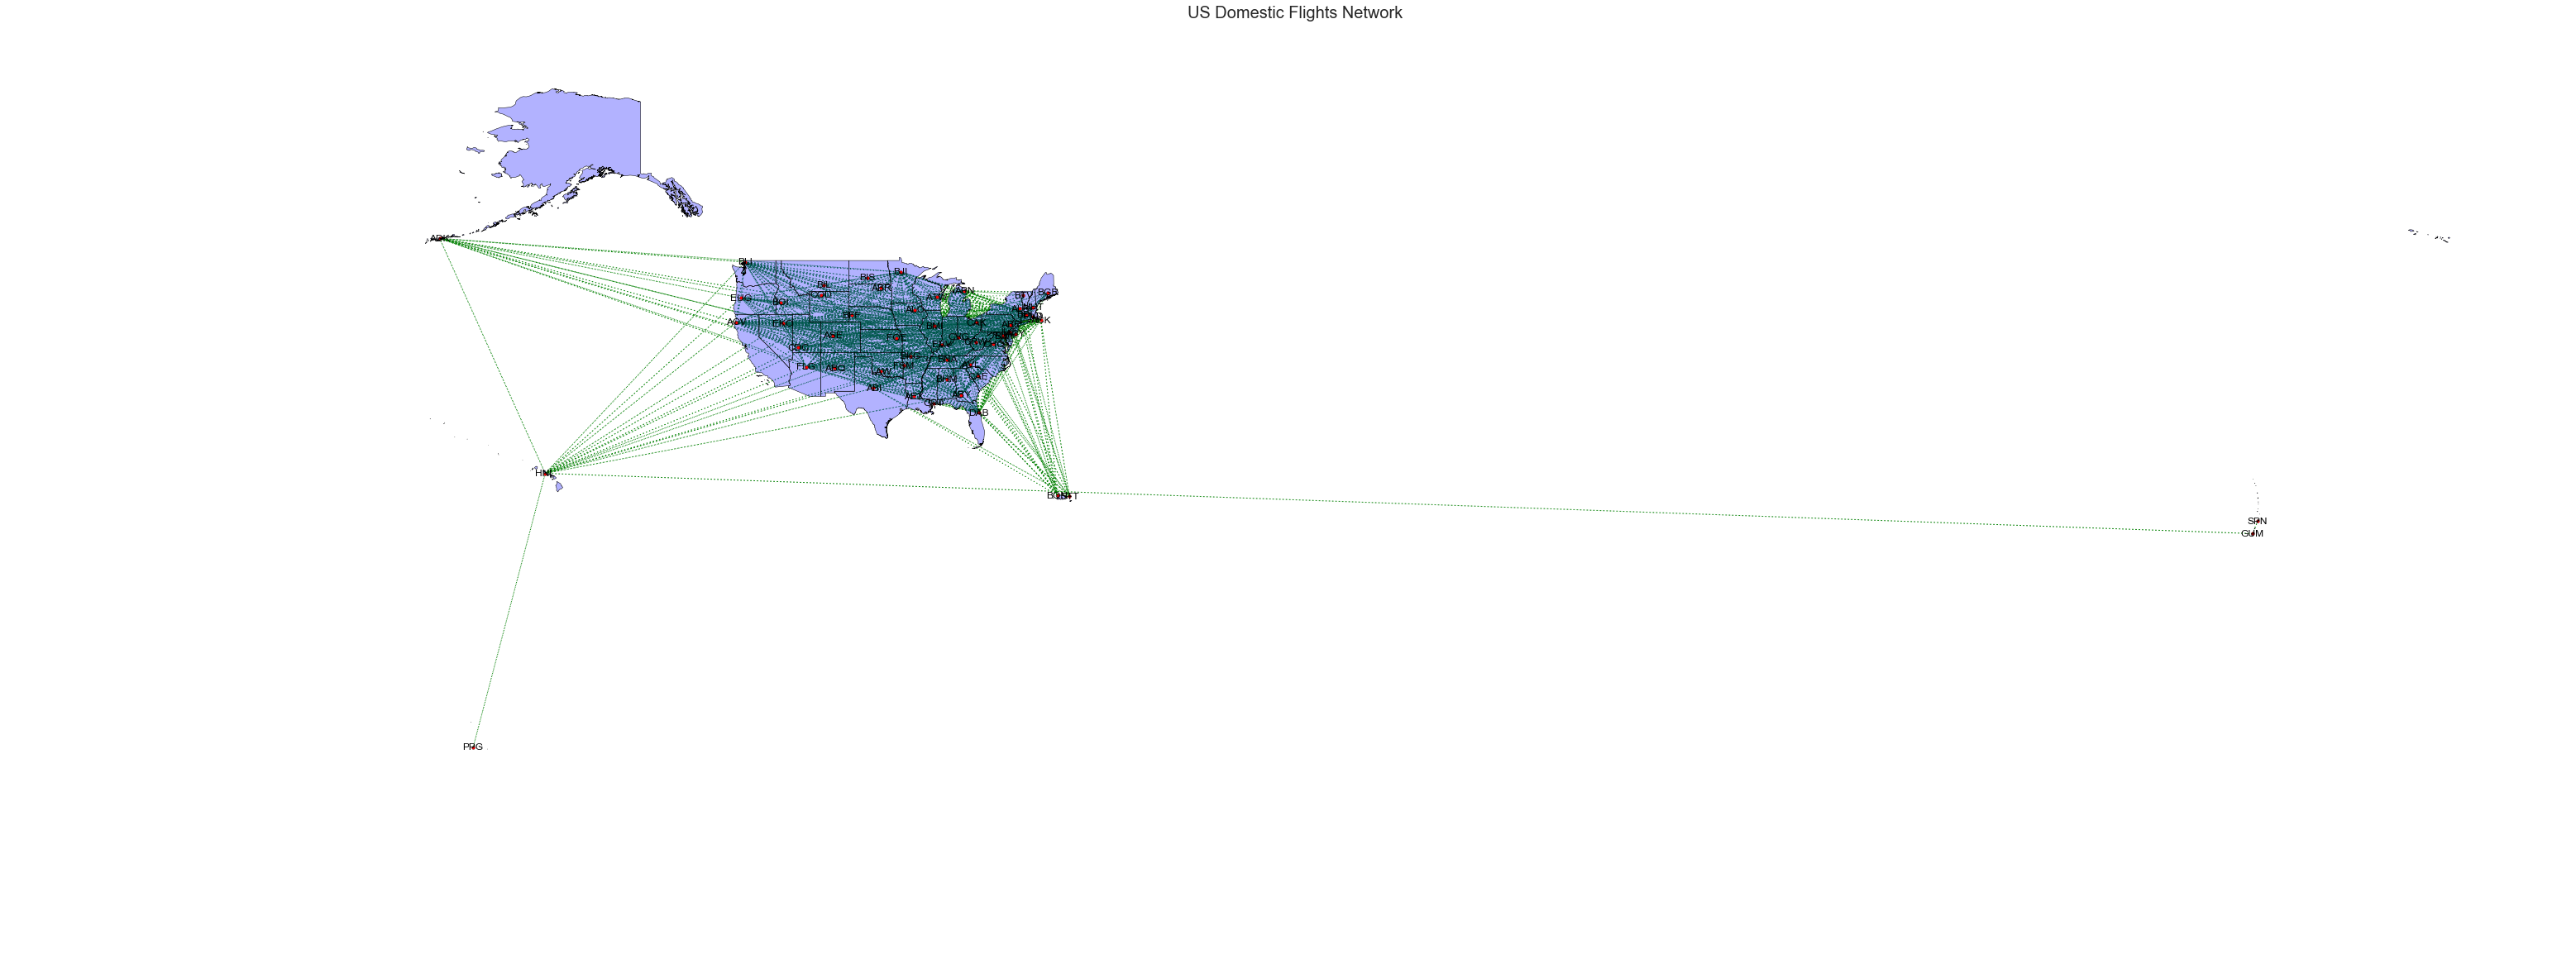

In [31]:
f, ax = pl.subplots(figsize=(55,20))

states.plot(c = 'k', linewidth = .5, ax = ax,  color= 'Blue', label = 'parks', alpha=.3)
pl.axis('off')

nx.draw(R,pos=airportpos,with_labels=True,arrows=False,node_size=15,style='dotted',edge_color='green')
pl.title("US Domestic Flights Network", size=20)

In [32]:
airport[airport.Airport=='YAK']

,Airport,City,Latitude,Longitude,Name,Total_Flights,dest_count,geometry,id,origin_count,state,longlat
332,YAK,Yakutat,59.3012,-139.3937,Yakutat,4345.0,2172.0,POINT (-139.3937 59.3012),332,2173.0,0,"(-139.3937, 59.3012)"


In [33]:
print list(R.nodes())

['EKO', 'ILG', 'CRW', 'ACK', 'AEX', 'HNL', 'GUM', 'CAK', 'BOI', 'BGR', 'COD', 'CVG', 'ACY', 'BNA', 'EVV', 'ABE', 'BIL', 'BKG', 'PPG', 'DAB', 'BMI', 'CAE', 'ASE', 'BDL', 'BWI', 'BIS', 'PVD', 'BFF', 'BQN', 'ABI', 'EUG', 'FSM', 'STT', 'ABQ', 'ABR', 'BLI', 'GPT', 'ABY', 'MHT', 'CHO', 'ADK', 'ALO', 'BTV', 'BHM', 'ATW', 'FOE', 'CDC', 'ALB', 'BJI', 'AVL', 'SPN', 'APN', 'LAW', 'FLG', 'ACV']


In [34]:
airport['Connectivity_Score'] = np.nan
airport.loc[airport['Airport'].isin(list(R.nodes()))]
Averageshortest = []
for node in list(R.nodes()):
    x = float(sum(zip(*nx.single_source_shortest_path_length(R,node).items())[1]))/\
    len(nx.single_source_shortest_path_length(R,node))
    Averageshortest.append(x)
    airport.loc[airport.Airport==node,'Connectivity_Score'] = x
    
Averageshortest[:5]

[1.290909090909091,
 1.9454545454545455,
 1.9272727272727272,
 1.509090909090909,
 1.5636363636363637]

In [35]:
dfcon = airport[['Airport','state','Connectivity_Score']]#.sort_values('Connectivity_Score')
dfcon.dropna(inplace = True)
dfcon.rename(columns={'state':'NAME'}, inplace=True)

C:\Users\ferna\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\ferna\Anaconda2\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [36]:
states.head(3)

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry
0,0400000US01,131173688951,4593686489,01,00,Alabama,01,01779775,AL,"(POLYGON ((-88.053375 30.506987, -88.051087999..."
1,0400000US02,1477946266785,245390495931,02,00,Alaska,02,01785533,AK,"(POLYGON ((-134.737262 58.261354, -134.73441 5..."
2,0400000US04,294198560125,1027346486,04,00,Arizona,04,01779777,AZ,"POLYGON ((-114.816294 32.508038, -114.814321 3..."


In [37]:
states = states.merge(dfcon, on ='NAME', how='outer' )
states.dropna(inplace=True)

In [38]:
len(states)

55

In [39]:
len(states.Connectivity_Score.dropna())

55

In [40]:
connect = states.Connectivity_Score
connect = ps.Quantiles(connect, k=6)
connect

              Quantiles               
 
Lower          Upper             Count
        x[i] <= 1.273               10
1.273 < x[i] <= 1.418               10
1.418 < x[i] <= 1.655                8
1.655 < x[i] <= 1.745               10
1.745 < x[i] <= 1.855                8
1.855 < x[i] <= 3.545                9

In [41]:
states[states.Connectivity_Score==0]

,AFFGEOID,ALAND,AWATER,GEOID,LSAD,NAME,STATEFP,STATENS,STUSPS,geometry,Airport,Connectivity_Score


In [42]:
connect.yb

array([3, 3, 1, 3, 0, 0, 3, 5, 0, 2, 4, 0, 2, 3, 4, 1, 0, 5, 4, 1, 0, 3, 5,
       3, 1, 3, 5, 0, 5, 5, 4, 5, 3, 1, 2, 2, 4, 2, 1, 1, 3, 4, 0, 1, 1, 2,
       4, 2, 0, 0, 1, 2, 5, 5, 4])

[None, None, None, None, None, None, None, None]

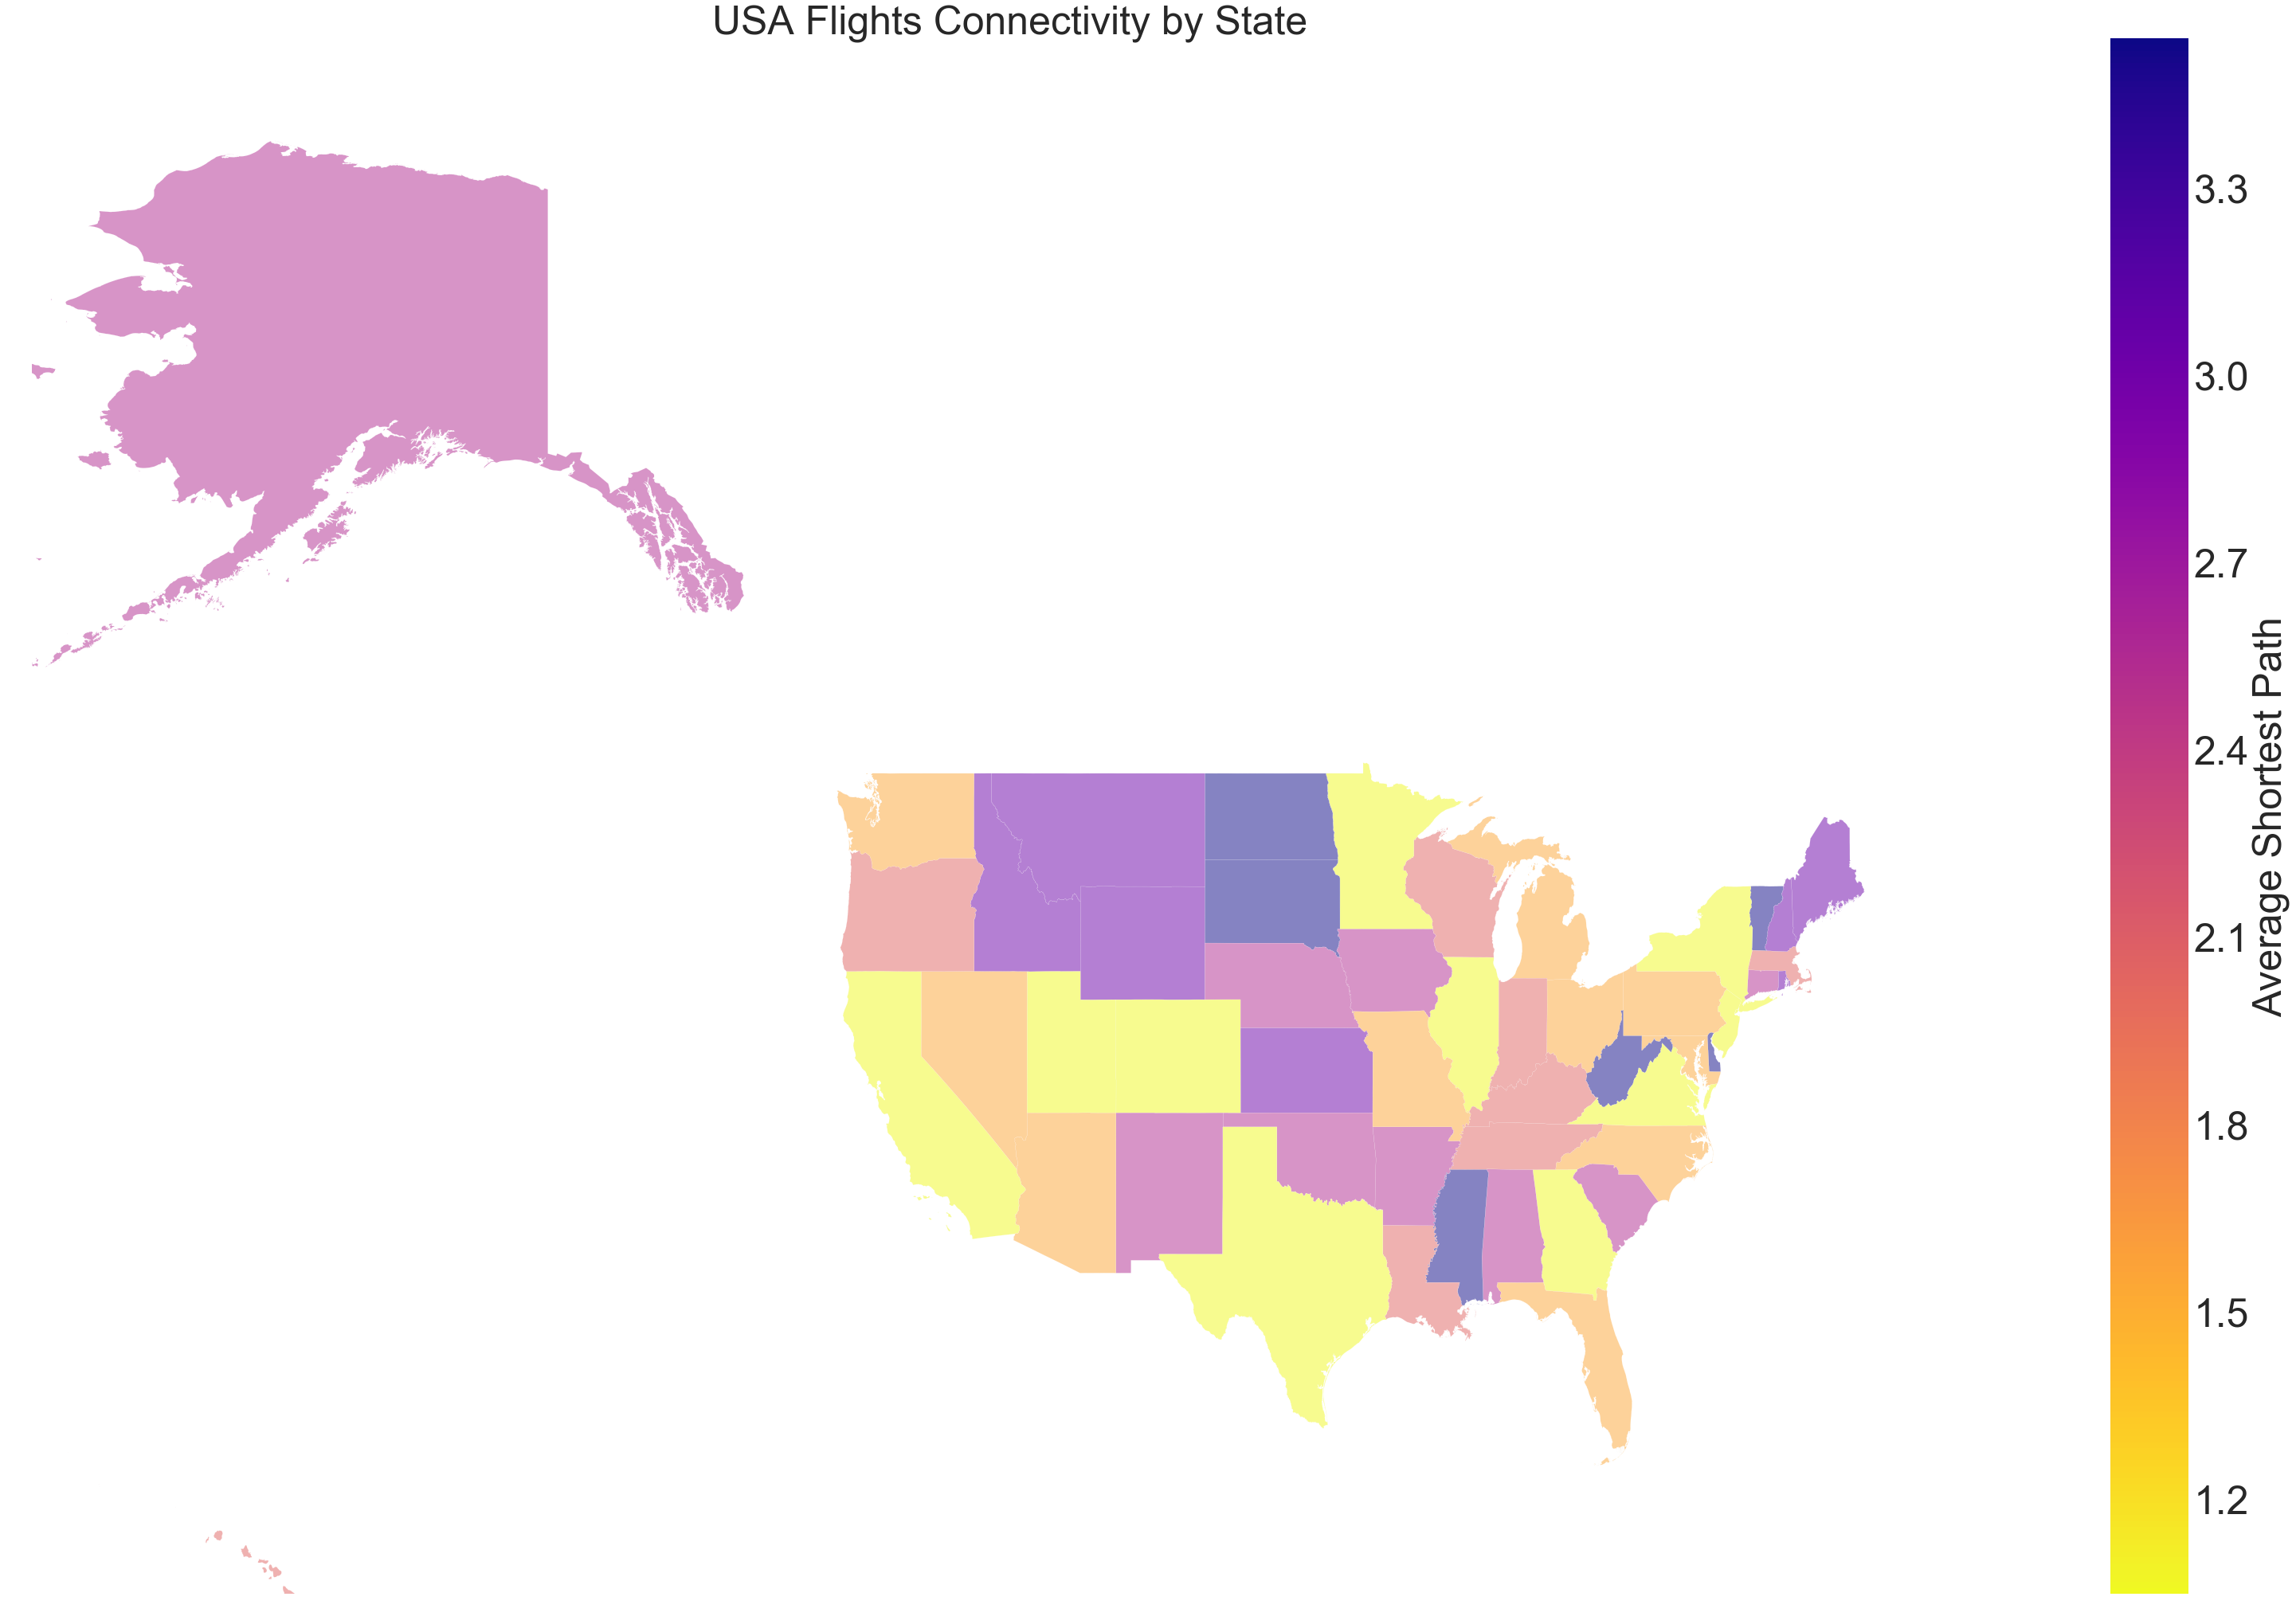

In [43]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap  
from matplotlib import colors
import matplotlib.cm as cm
mycolor = ListedColormap('k')

f, ax = pl.subplots(figsize=(55,35))
pl.xlabel('longitude')
pl.ylabel('latitude')
pl.ylim(20, 75)
pl.xlim(-170,-60)


states.assign(cl = connect.yb).plot(column = 'cl', categorical = True, k = 10, linewidth = .1,
                                          ax=ax, cmap='plasma_r', edgecolor='white', legend=False)

#tracks.assign(cl = households.yb).plot(column = 'cl', categorical = True, k = 10, linewidth = .1,
#                                          ax=ax, cmap='plasma', edgecolor='white', legend=False)

pl.axis('off')
pl.title("USA Flights Connectivity by State", size=50)

normalize = mcolors.Normalize(vmin=states.Connectivity_Score.min(),vmax=states.Connectivity_Score.max())
colormap = cm.plasma_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)

#scalarmappaple.set_array(tracks.assign(cl = households.yb))
#pl.colorbar.tick_params(labelsize=80) 

scalarmappaple.set_array(states.assign(cl = connect.yb))

#cb.ax.tick_params(labelsize=font_size)
cbar =pl.colorbar(scalarmappaple, ax=ax )
#cbar = pl.colorbar(G, ticks=range(g1,g2+1))     
cbar.ax.set_ylabel('Average Shortest Path', fontsize=50) 
cl = pl.getp(cbar.ax, 'ymajorticklabels') 
pl.setp(cl, fontsize=50) 
#pl.colorbar?
#ticks = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)

In [44]:
states[['NAME','Connectivity_Score']].sort_values('Connectivity_Score').head(10)

,NAME,Connectivity_Score
12,Illinois,1.054545
9,Georgia,1.072727
49,Texas,1.145455
5,Colorado,1.181818
17,Minnesota,1.200000
21,New Jersey,1.218182
43,New York,1.254545
50,Virginia,1.254545
28,Utah,1.254545
4,California,1.272727


In [45]:
states[['NAME','Connectivity_Score']].sort_values('Connectivity_Score',ascending=False).head(10)

,NAME,Connectivity_Score
54,Commonwealth of the Northern Mariana Islands,3.545455
32,American Samoa,2.618182
53,Guam,2.581818
18,Mississippi,1.945455
7,Delaware,1.945455
30,West Virginia,1.927273
23,North Dakota,1.890909
27,South Dakota,1.872727
29,Vermont,1.872727
15,Kansas,1.854545


In [52]:
print 'Number of Nodes/Airports in the complete Netwrok: ',len(list(G.node))
print 'Number of Nodes/Airports in the reduced Netwrok: ',len(list(R.node))

Number of Nodes/Airports in the complete Netwrok:  334
Number of Nodes/Airports in the reduced Netwrok:  55


In [53]:
nx.write_pajek(R, 'C:/spark/Flight_Project/Output/USAFlightsReduced.net',encoding='UTF-8')